# Twitter Bot or Not?

Model Comparison: 
* RandomForest 
* XGBoost

Oversampling Method Comparison: 
* None
* RandomOversampler
* SMOTE
* ADASYN

In [90]:
# Basics
import pandas as pd
import numpy as np
from collections import Counter

# Visuals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from visualize import *

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model support
from sklearn.model_selection import (train_test_split, cross_val_score, learning_curve, 
                                    KFold, StratifiedKFold, GridSearchCV)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, make_scorer,
                             plot_confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve)
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

## Data import and setup

In [2]:
raw_df = pd.read_csv('data_files/twitter_human_bots_dataset.csv.zip', index_col=False)

# drop funny index column
raw_df.drop(columns=['Unnamed: 0'], inplace=True)

# Binary classifications for bots and boolean values
raw_df['bot'] = raw_df['account_type'].apply(lambda x: 1 if x == 'bot' else 0)
raw_df['default_profile'] = raw_df['default_profile'].astype(int)
raw_df['default_profile'] = raw_df['default_profile'].astype(int)
raw_df['default_profile_image'] = raw_df['default_profile_image'].astype(int)
raw_df['geo_enabled'] = raw_df['geo_enabled'].astype(int)
raw_df['verified'] = raw_df['verified'].astype(int)

# datetime conversion
raw_df['created_at'] = pd.to_datetime(raw_df['created_at'])
# hour created
raw_df['hour_created'] = pd.to_datetime(raw_df['created_at']).dt.hour



In [3]:
# usable df setup
df = raw_df[['bot', 'screen_name', 'created_at', 'hour_created', 'verified', 'location', 'geo_enabled', 'lang', 'default_profile', 
              'default_profile_image', 'favourites_count', 'followers_count', 'friends_count', 'statuses_count',
             'average_tweets_per_day', 'account_age_days']]

In [4]:
# Interesting features to look at: 
df['avg_daily_followers'] = np.round(df['followers_count'] / df['account_age_days'])
df['avg_daily_friends'] = np.round(df['followers_count'] / df['account_age_days'])
df['avg_daily_favorites'] = np.round(df['followers_count'] / df['account_age_days'])

# Log transformations for highly skewed data
df['friends_log'] = np.round(np.log(1 + df['friends_count']), 3)
df['followers_log'] = np.round(np.log(1 + df['followers_count']), 3)
df['favs_log'] = np.round(np.log(1 + df['favourites_count']), 3)
df['avg_daily_tweets_log'] = np.round(np.log(1+ df['average_tweets_per_day']), 3)

# Possible popularity metrics
df['popularity'] = np.round(df['friends_log'] * df['followers_log'], 3)
df['tweet_to_followers'] = np.round(np.log( 1+ df['statuses_count']) * np.log(1+ df['followers_count']), 3)

# Log-transformed daily acquisition metrics for dist. plots
df['follower_acq_rate'] = np.round(np.log(1 + (df['followers_count'] / df['account_age_days'])), 3)
df['friends_acq_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)
df['favs_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)

<ipython-input-4-f05b6e00d5a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_daily_followers'] = np.round(df['followers_count'] / df['account_age_days'])
<ipython-input-4-f05b6e00d5a8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_daily_friends'] = np.round(df['followers_count'] / df['account_age_days'])
<ipython-input-4-f05b6e00d5a8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [5]:
del raw_df

In [6]:
num_bots = len(df[df['bot'] == 1])
num_humans = len(df[df['bot'] == 0])

print("Number of bots: ", num_bots)
print("Number of humans: ", num_humans)
print("Bots / Total %: ", (num_bots / len(df)) * 100)

Number of bots:  12425
Number of humans:  25013
Bots / Total %:  33.18820449810353


In [129]:
features = ['verified', 
            #'created_at',
            #'hour_created',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            'popularity', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            'favs_rate'
           ]

X = df[features]
y = df['bot']

X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=34)

## No Oversampling

In [130]:
kf = KFold(n_splits=3, shuffle=True, random_state=33)

forest_acc, forest_prec, forest_rec, forest_f1, forest_roc_auc = [], [], [], [], []
xgb_acc, xgb_prec, xgb_rec, xgb_f1, xgb_roc_auc = [], [], [], [], []

X_kf, y_kf = np.array(X), np.array(y)

for train_ind, val_ind in kf.split(X, y):

    X_train, y_train = X_kf[train_ind], y_kf[train_ind]
    X_val, y_val = X_kf[val_ind], y_kf[val_ind]

    # Random Forest
    forest = RandomForestClassifier()
    forest.fit(X_train, y_train)
    forest_pred = forest.predict(X_val)

    forest_acc.append(accuracy_score(y_val, forest_pred))
    forest_prec.append(precision_score(y_val, forest_pred))
    forest_rec.append(recall_score(y_val, forest_pred))
    forest_f1.append(f1_score(y_val, forest_pred))
    forest_roc_auc.append(roc_auc_score(y_val, forest.predict_proba(X_val)[:,1]))

    # XGBoost
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_val)

    xgb_acc.append(accuracy_score(y_val, xgb_pred))
    xgb_prec.append(precision_score(y_val, xgb_pred))
    xgb_rec.append(recall_score(y_val, xgb_pred))
    xgb_f1.append(f1_score(y_val, xgb_pred))
    xgb_roc_auc.append(roc_auc_score(y_val, xgb.predict_proba(X_val)[:,1]))


print("RandomForest")
print("------------")
print(f'Accuracy:  {np.mean(forest_acc):.5f} +- {np.std(forest_acc):5f}')
print(f'Precision: {np.mean(forest_prec):.5f} +- {np.std(forest_prec):5f}')
print(f'Recall:    {np.mean(forest_rec):.5f} +- {np.std(forest_rec):5f}')
print(f'F1 Score:  {np.mean(forest_f1):.5f} +- {np.std(forest_f1):5f}')
print(f'ROC AUC:   {np.mean(forest_roc_auc):.5f} +- {np.std(forest_roc_auc):5f}')
print("")
print("XGBoost")
print("-------")
print(f'Accuracy:  {np.mean(xgb_acc):.5f} +- {np.std(xgb_acc):5f}')
print(f'Precision: {np.mean(xgb_prec):.5f} +- {np.std(xgb_prec):5f}')
print(f'Recall:    {np.mean(xgb_rec):.5f} +- {np.std(xgb_rec):5f}')
print(f'F1 Score:  {np.mean(xgb_f1):.5f} +- {np.std(xgb_f1):5f}')
print(f'ROC AUC:   {np.mean(xgb_roc_auc):.5f} +- {np.std(xgb_roc_auc):5f}')

RandomForest
------------
Accuracy:  0.87327 +- 0.003574
Precision: 0.85106 +- 0.003062
Recall:    0.75007 +- 0.013341
F1 Score:  0.79729 +- 0.006354
ROC AUC:   0.92615 +- 0.004390

XGBoost
-------
Accuracy:  0.87373 +- 0.003636
Precision: 0.84463 +- 0.002626
Recall:    0.75992 +- 0.015917
F1 Score:  0.79993 +- 0.007712
ROC AUC:   0.92685 +- 0.002910


## SMOTE

In [131]:
kf = KFold(n_splits=5, shuffle=True, random_state=614)

xgb_acc, xgb_prec, xgb_rec, xgb_f1, xgb_roc_auc = [], [], [], [], []

X_kf, y_kf = np.array(X), np.array(y)

for train_ind, val_ind in kf.split(X_smoted, y_smoted):

    X_train, y_train = X_kf[train_ind], y_kf[train_ind]
    X_val, y_val = X_kf[val_ind], y_kf[val_ind]
    
    # SMOTE training values
    X_train_smoted, y_train_smoted = SMOTE(random_state=2049).fit_sample(X_train, y_train)
    
    # Random Forest
    forest = RandomForestClassifier()
    forest.fit(X_train_smoted, y_train_smoted)
    forest_pred = forest.predict(X_val)

    forest_acc.append(accuracy_score(y_val, forest_pred))
    forest_prec.append(precision_score(y_val, forest_pred))
    forest_rec.append(recall_score(y_val, forest_pred))
    forest_f1.append(f1_score(y_val, forest_pred))
    forest_roc_auc.append(roc_auc_score(y_val, forest.predict_proba(X_val)[:,1]))

    # XGBoost
    xgb = XGBClassifier()
    xgb.fit(X_train_smoted, y_train_smoted)
    xgb_pred = xgb.predict(X_val)

    xgb_acc.append(accuracy_score(y_val, xgb_pred))
    xgb_prec.append(precision_score(y_val, xgb_pred))
    xgb_rec.append(recall_score(y_val, xgb_pred))
    xgb_f1.append(f1_score(y_val, xgb_pred))
    xgb_roc_auc.append(roc_auc_score(y_val, xgb.predict_proba(X_val)[:,1]))


print("RandomForest")
print("------------")
print(f'Accuracy:  {np.mean(forest_acc):.5f} +- {np.std(forest_acc):5f}')
print(f'Precision: {np.mean(forest_prec):.5f} +- {np.std(forest_prec):5f}')
print(f'Recall:    {np.mean(forest_rec):.5f} +- {np.std(forest_rec):5f}')
print(f'F1 Score:  {np.mean(forest_f1):.5f} +- {np.std(forest_f1):5f}')
print(f'ROC AUC:   {np.mean(forest_roc_auc):.5f} +- {np.std(forest_roc_auc):5f}')
print("")
print("XGBoost")
print("-------")
print(f'Accuracy:  {np.mean(xgb_acc):.5f} +- {np.std(xgb_acc):5f}')
print(f'Precision: {np.mean(xgb_prec):.5f} +- {np.std(xgb_prec):5f}')
print(f'Recall:    {np.mean(xgb_rec):.5f} +- {np.std(xgb_rec):5f}')
print(f'F1 Score:  {np.mean(xgb_f1):.5f} +- {np.std(xgb_f1):5f}')
print(f'ROC AUC:   {np.mean(xgb_roc_auc):.5f} +- {np.std(xgb_roc_auc):5f}')

RandomForest
------------
Accuracy:  0.87036 +- 0.003810
Precision: 0.82851 +- 0.019905
Recall:    0.76956 +- 0.018904
F1 Score:  0.79753 +- 0.007001
ROC AUC:   0.92606 +- 0.003713

XGBoost
-------
Accuracy:  0.87259 +- 0.002498
Precision: 0.82089 +- 0.006591
Recall:    0.78777 +- 0.008624
F1 Score:  0.80395 +- 0.005084
ROC AUC:   0.92863 +- 0.003112


# Tuning

In [132]:
df2 = df.copy()

features = ['verified', 
            #'created_at',
            #'hour_created',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            'popularity', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            'favs_rate'
           ]

X = df2[features]
y = df2['bot']

In [133]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=34)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=214)

X_smoted, y_smoted = SMOTE(random_state=4214).fit_sample(X_train, y_train)

## RandomForest

### Baseline

In [134]:
forest = RandomForestClassifier(n_jobs=-1)

forest.fit(X_smoted, y_smoted)
forest_pred = forest.predict(X_val)

print(f'Accuracy:  {accuracy_score(y_val, forest_pred):5f}')
print(f'Precision: {precision_score(y_val, forest_pred):5f}')
print(f'Recall:    {recall_score(y_val, forest_pred):5f}')
print(f'F1 Score:  {f1_score(y_val, forest_pred):5f}')
print(f'ROC AUC:   {roc_auc_score(y_val, forest.predict_proba(X_val)[:,1]):5f}')

Accuracy:  0.865301
Precision: 0.796881
Recall:    0.799618
F1 Score:  0.798247
ROC AUC:   0.927583


In [135]:
print(classification_report(y_val, forest_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      5242
           1       0.80      0.80      0.80      2620

    accuracy                           0.87      7862
   macro avg       0.85      0.85      0.85      7862
weighted avg       0.87      0.87      0.87      7862



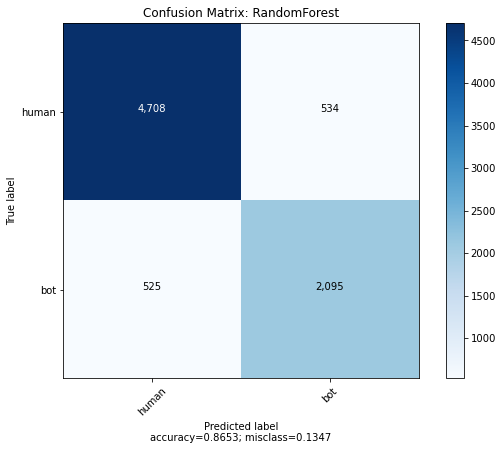

In [136]:
model = 'RandomForest'

forest_cm = confusion_matrix(y_val, forest_pred)
plot_cm(forest_cm, normalize=False, target_names=['human', 'bot'], title='Confusion Matrix: {}'.format(model))

ROC AUC score =  0.9275832529976613


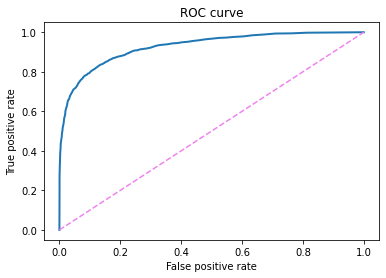

In [137]:
fpr, tpr, thresholds = roc_curve(y_val, forest.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, forest.predict_proba(X_val)[:,1]))

### Tuning

In [84]:
len(features)

14

In [103]:
estimator = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    'min_samples_split': [2, 3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': ['sqrt', None]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring = 'f1',
    n_jobs = 10,
    cv = 5,
    verbose=True
)

In [104]:
#grid_search.fit(X_smoted, y_smoted)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    8.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  2.2min
[Parallel(n_jobs=10)]: Done 320 out of 320 | elapsed:  7.0min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=10,
             param_grid={'max_depth': [3, 5, 15, 25],
                         'max_features': ['sqrt', None],
                         'min_samples_split': [2, 3, 5, 10],
                         'n_estimators': [100, 300]},
             scoring='f1', verbose=True)

In [105]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=25, max_features='sqrt', n_estimators=300,
                       n_jobs=-1, random_state=42)

**Best estimator for this round**
```
RandomForestClassifier(max_depth=25, max_features='sqrt', n_estimators=300,
                       n_jobs=-1, random_state=42)
```
Params:
* max_features = 'sqrt`
* n_estimators = 300
* max_depth = 25

In [106]:
forest_pred = grid_search.predict(X_val)

print(f'Accuracy:  {accuracy_score(y_val, forest_pred):5f}')
print(f'Precision: {precision_score(y_val, forest_pred):5f}')
print(f'Recall:    {recall_score(y_val, forest_pred):5f}')
print(f'F1 Score:  {f1_score(y_val, forest_pred):5f}')
print(f'ROC AUC:   {roc_auc_score(y_val, grid_search.predict_proba(X_val)[:,1]):5f}')

Accuracy:  0.865556
Precision: 0.798624
Recall:    0.797710
F1 Score:  0.798167
ROC AUC:   0.928904


In [138]:
forest = RandomForestClassifier(max_features='sqrt', n_jobs=-1, n_estimators=300)

forest.fit(X_smoted, y_smoted)
forest_pred = forest.predict(X_val)

print(f'Accuracy:  {accuracy_score(y_val, forest_pred):5f}')
print(f'Precision: {precision_score(y_val, forest_pred):5f}')
print(f'Recall:    {recall_score(y_val, forest_pred):5f}')
print(f'F1 Score:  {f1_score(y_val, forest_pred):5f}')
print(f'ROC AUC:   {roc_auc_score(y_val, forest.predict_proba(X_val)[:,1]):5f}')

Accuracy:  0.864665
Precision: 0.796494
Recall:    0.797710
F1 Score:  0.797101
ROC AUC:   0.928464


Seems like `max_depth` parameter isn't that important here

#### Cross Validation with Best Model

In [139]:
df4 = df.copy()

features = ['verified', 
            #'created_at',
            #'hour_created',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            'popularity', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            'favs_rate'
           ]

X = df4[features]
y = df4['bot']

X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=222)

In [140]:
kf = KFold(n_splits=5, shuffle=True, random_state=614)

forest_acc, forest_prec, forest_rec, forest_f1, forest_roc_auc = [], [], [], [], []

X_kf, y_kf = np.array(X), np.array(y)

for train_ind, val_ind in kf.split(X_smoted, y_smoted):

    X_train, y_train = X_kf[train_ind], y_kf[train_ind]
    X_val, y_val = X_kf[val_ind], y_kf[val_ind]
    
    # SMOTE training values
    X_train_smoted, y_train_smoted = SMOTE(random_state=2049).fit_sample(X_train, y_train)
    

    # Random Forest
    forest = RandomForestClassifier(max_features='sqrt', n_jobs=-1, n_estimators=300)
    forest.fit(X_train_smoted, y_train_smoted)
    forest_pred = forest.predict(X_val)

    forest_acc.append(accuracy_score(y_val, forest_pred))
    forest_prec.append(precision_score(y_val, forest_pred))
    forest_rec.append(recall_score(y_val, forest_pred))
    forest_f1.append(f1_score(y_val, forest_pred))
    forest_roc_auc.append(roc_auc_score(y_val, forest.predict_proba(X_val)[:,1]))

print("RandomForest")
print("------------")
print(f'Accuracy:  {np.mean(forest_acc):.5f} +- {np.std(forest_acc):5f}')
print(f'Precision: {np.mean(forest_prec):.5f} +- {np.std(forest_prec):5f}')
print(f'Recall:    {np.mean(forest_rec):.5f} +- {np.std(forest_rec):5f}')
print(f'F1 Score:  {np.mean(forest_f1):.5f} +- {np.std(forest_f1):5f}')
print(f'ROC AUC:   {np.mean(forest_roc_auc):.5f} +- {np.std(forest_roc_auc):5f}')

RandomForest
------------
Accuracy:  0.86755 +- 0.002660
Precision: 0.81540 +- 0.014635
Recall:    0.77607 +- 0.006013
F1 Score:  0.79518 +- 0.008127
ROC AUC:   0.92376 +- 0.003313


#### Re-train and look at Confusion Matrix

In [141]:
df5 = df.copy()

features = ['verified', 
            #'created_at',
            #'hour_created',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            'popularity', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            'favs_rate'
           ]

X = df5[features]
y = df5['bot']

X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=222)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=333)

X_smoted, y_smoted = SMOTE(random_state=444).fit_sample(X_train, y_train)

In [142]:
forest = RandomForestClassifier(max_features='sqrt', n_jobs=-1, n_estimators=300)

forest.fit(X_smoted, y_smoted)
forest_pred = forest.predict(X_val)

print(classification_report(y_val, forest_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      5199
           1       0.80      0.79      0.79      2663

    accuracy                           0.86      7862
   macro avg       0.85      0.84      0.84      7862
weighted avg       0.86      0.86      0.86      7862



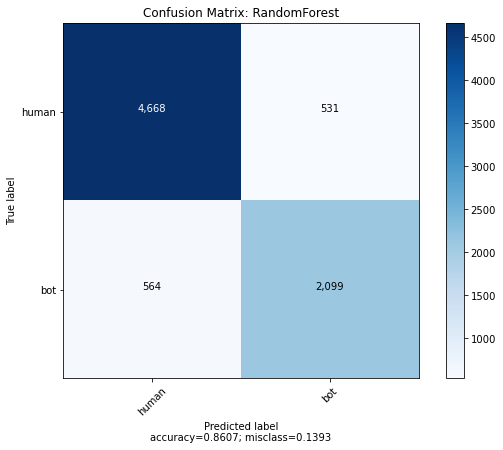

In [143]:
model = 'RandomForest'

forest_cm = confusion_matrix(y_val, forest_pred)
plot_cm(forest_cm, normalize=False, target_names=['human', 'bot'], title='Confusion Matrix: {}'.format(model))

## XGBoost

### Baseline

In [144]:
# XGBoost
xgb = XGBClassifier()
xgb.fit(X_smoted, y_smoted)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [145]:
xgb.fit(X_smoted, y_smoted)
xgb_pred = xgb.predict(X_val)

print(f'Accuracy:  {accuracy_score(y_val, xgb_pred):5f}')
print(f'Precision: {precision_score(y_val, xgb_pred):5f}')
print(f'Recall:    {recall_score(y_val, xgb_pred):5f}')
print(f'F1 Score:  {f1_score(y_val, xgb_pred):5f}')
print(f'ROC AUC:   {roc_auc_score(y_val, xgb.predict_proba(X_val)[:,1]):5f}')

Accuracy:  0.856016
Precision: 0.788541
Recall:    0.785580
F1 Score:  0.787058
ROC AUC:   0.918236


In [146]:
print(classification_report(y_val, xgb_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      5199
           1       0.79      0.79      0.79      2663

    accuracy                           0.86      7862
   macro avg       0.84      0.84      0.84      7862
weighted avg       0.86      0.86      0.86      7862



ROC AUC score =  0.9182361754336623


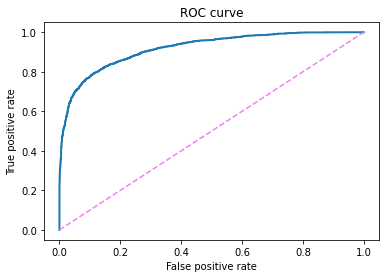

In [147]:
fpr, tpr, thresholds = roc_curve(y_val, xgb.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, xgb.predict_proba(X_val)[:,1]))

### Tuning

#### Round 1 
* Target = roc_auc
* Params:
    * max_depth, 
    * n_estimators, 
    * learning_rate

In [26]:
estimator = XGBClassifier(
    nthread=4,
    seed=42
)

In [27]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [30]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [31]:
#grid_search.fit(X_smoted, y_smoted)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  4.2min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  8.2min
[Parallel(n_jobs=10)]: Done 960 out of 960 | elapsed: 10.9min finished


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=No

In [32]:
#grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=180, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

**Best estimator for this round**

```
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=180, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)
```

best params:
* learning_rate=0.1
* n_estimators=180
* max_depth=9

In [36]:
xgb_pred = grid_search.predict(X_val)

print(f'Accuracy:  {accuracy_score(y_val, xgb_pred):5f}')
print(f'Precision: {precision_score(y_val, xgb_pred):5f}')
print(f'Recall:    {recall_score(y_val, xgb_pred):5f}')
print(f'F1 Score:  {f1_score(y_val, xgb_pred):5f}')
print(f'ROC AUC:   {roc_auc_score(y_val, grid_search.predict_proba(X_val)[:,1]):5f}')

Accuracy: 0.867591
Precision: 0.805652
Recall: 0.794275
F1 Score: 0.799923
ROC AUC: 0.931059


In [34]:
print(classification_report(y_val, xgb_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      5242
           1       0.81      0.79      0.80      2620

    accuracy                           0.87      7862
   macro avg       0.85      0.85      0.85      7862
weighted avg       0.87      0.87      0.87      7862



ROC AUC score =  0.9310594697554399


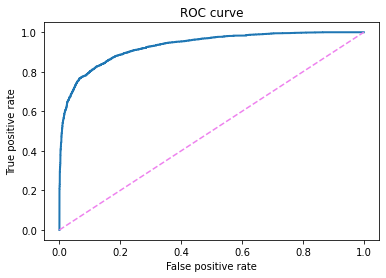

In [35]:
fpr, tpr, thresholds = roc_curve(y_val, grid_search.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, grid_search.predict_proba(X_val)[:,1]))

#### Round 2
* Target: f1 score
* params
    * max_depth
    * n_estimators
    * learning_rate

In [37]:
estimator = XGBClassifier(
    nthread=4,
    seed=42
)

In [38]:
parameters = {
    'max_depth': range (8, 12, 1),
    'n_estimators': range(100, 220, 40),
    'learning_rate': [0.1, 0.05]
}

In [39]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'f1',
    n_jobs = 10,
    cv = 5,
    verbose=True
)

In [40]:
#grid_search.fit(X_smoted, y_smoted)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   32.3s
[Parallel(n_jobs=10)]: Done 120 out of 120 | elapsed:  2.3min finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=Non

In [41]:
#grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=180, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

**Best Estimator for this round**
```
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=180, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)
```
best params:
* **learning_rate=0.1**
* **n_estimators=180**
* max_depth=11


max_depth: 9-11

In [42]:
xgb_pred = grid_search.predict(X_val)

print(f'Accuracy:  {accuracy_score(y_val, xgb_pred):5f}')
print(f'Precision: {precision_score(y_val, xgb_pred):5f}')
print(f'Recall:    {recall_score(y_val, xgb_pred):5f}')
print(f'F1 Score:  {f1_score(y_val, xgb_pred):5f}')
print(f'ROC AUC:   {roc_auc_score(y_val, grid_search.predict_proba(X_val)[:,1]):5f}')

Accuracy: 0.865556
Precision: 0.797714
Recall: 0.799237
F1 Score: 0.798475
ROC AUC: 0.929095


ROC AUC score =  0.929095116950293


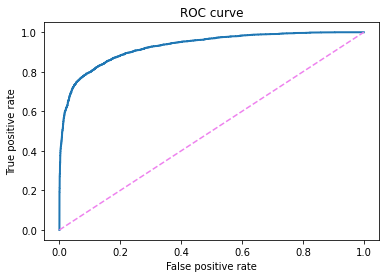

In [43]:
fpr, tpr, thresholds = roc_curve(y_val, grid_search.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, grid_search.predict_proba(X_val)[:,1]))

#### Round 3
* Target: f1
* Set estimator params: 
    * learning_rate = 0.1
    * n_estimators = 180
* Params: 
    * subsample
    * colsammple_bylevel
    * colsample_bytree
    * min_child_weight
    * max_depth

In [46]:
estimator = XGBClassifier(
    learning_rate=0.1,
    n_estimators=180,
    nthread=4,
    seed=42
)

parameters = {
    'subsample': [.8, 1],
    'colsample_bylevel' : [.6, .8, 1], 
    'colsample_bytree' : [.6, .8, 1],
    'min_child_weight' : [1, 2, 3],     
    'max_depth': range (9, 12, 1)
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'f1',
    n_jobs = 10,
    cv = 5,
    verbose=True
)

In [47]:
#grid_search.fit(X_smoted, y_smoted)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   19.8s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  6.7min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed: 14.2min
[Parallel(n_jobs=10)]: Done 810 out of 810 | elapsed: 15.1min finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=180, n_jobs=...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=None, tree_method

In [48]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=180, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

**Best estimator for this round**
```
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=180, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)
```
Params:
* subsample = 0.8
* colsample_bylevel = 0.6
* colsample_bytree = 1.0
* min_child_weight = 1
* max_depth = 11

In [49]:
xgb_pred = grid_search.predict(X_val)

print(f'Accuracy:  {accuracy_score(y_val, xgb_pred):5f}')
print(f'Precision: {precision_score(y_val, xgb_pred):5f}')
print(f'Recall:    {recall_score(y_val, xgb_pred):5f}')
print(f'F1 Score:  {f1_score(y_val, xgb_pred):5f}')
print(f'ROC AUC:   {roc_auc_score(y_val, grid_search.predict_proba(X_val)[:,1]):5f}')

Accuracy: 0.872552
Precision: 0.812838
Recall: 0.802290
F1 Score: 0.807530
ROC AUC: 0.929495


ROC AUC score =  0.9294946352275076


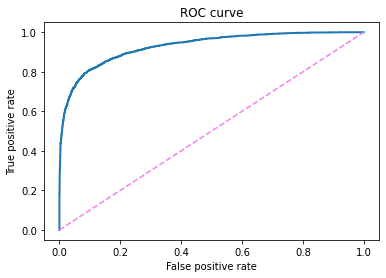

In [50]:
fpr, tpr, thresholds = roc_curve(y_val, grid_search.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, grid_search.predict_proba(X_val)[:,1]))

In [52]:
print(classification_report(y_val, xgb_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      5242
           1       0.81      0.80      0.81      2620

    accuracy                           0.87      7862
   macro avg       0.86      0.85      0.86      7862
weighted avg       0.87      0.87      0.87      7862



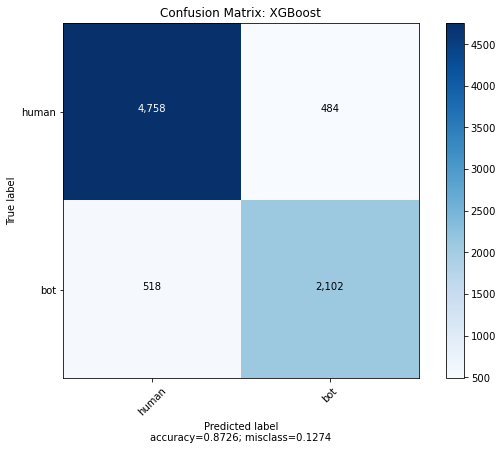

In [51]:
model = 'XGBoost'

xgb_cm = confusion_matrix(y_val, xgb_pred)
plot_cm(xgb_cm, normalize=False, target_names=['human', 'bot'], title='Confusion Matrix: {}'.format(model))

#### Cross Validation with Best Model

**Best XGBoost Model**

```
best_xgb = XGBClassifier(
                    learning_rate=0.1,
                    n_estimators=180,
                    nthread=4,
                    subsample = 0.8, 
                    colsample_bylevel = 0.6, 
                    colsample_bytree = 1.0, 
                    min_child_weight = 1, 
                    max_depth = 11
)x
```

In [149]:
df3 = df.copy()

features = ['verified', 
            #'created_at',
            #'hour_created',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            'popularity', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            'favs_rate'
           ]

X = df3[features]
y = df3['bot']

X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=2020)

In [150]:
kf = KFold(n_splits=5, shuffle=True, random_state=614)

xgb_acc, xgb_prec, xgb_rec, xgb_f1, xgb_roc_auc = [], [], [], [], []

X_kf, y_kf = np.array(X), np.array(y)

for train_ind, val_ind in kf.split(X_smoted, y_smoted):

    X_train, y_train = X_kf[train_ind], y_kf[train_ind]
    X_val, y_val = X_kf[val_ind], y_kf[val_ind]
    
    # SMOTE training values
    X_train_smoted, y_train_smoted = SMOTE(random_state=2049).fit_sample(X_train, y_train)

    # XGBoost
    xgb = XGBClassifier(
                    learning_rate=0.1,
                    n_estimators=180,
                    nthread=4,
                    subsample = 0.8, 
                    colsample_bylevel = 0.6, 
                    colsample_bytree = 1.0, 
                    min_child_weight = 1, 
                    max_depth = 11
    )
    xgb.fit(X_train_smoted, y_train_smoted)
    xgb_pred = xgb.predict(X_val)

    xgb_acc.append(accuracy_score(y_val, xgb_pred))
    xgb_prec.append(precision_score(y_val, xgb_pred))
    xgb_rec.append(recall_score(y_val, xgb_pred))
    xgb_f1.append(f1_score(y_val, xgb_pred))
    xgb_roc_auc.append(roc_auc_score(y_val, xgb.predict_proba(X_val)[:,1]))

print("XGBoost cross-validated scoring")
print("-------------------------------")
print(f'Accuracy:  {np.mean(xgb_acc):.5f} +- {np.std(xgb_acc):5f}')
print(f'Precision: {np.mean(xgb_prec):.5f} +- {np.std(xgb_prec):5f}')
print(f'Recall:    {np.mean(xgb_rec):.5f} +- {np.std(xgb_rec):5f}')
print(f'F1 Score:  {np.mean(xgb_f1):.5f} +- {np.std(xgb_f1):5f}')
print(f'ROC AUC:   {np.mean(xgb_roc_auc):.5f} +- {np.std(xgb_roc_auc):5f}')

XGBoost cross-validated scoring
-------------------------------
Accuracy:  0.87109 +- 0.005812
Precision: 0.82466 +- 0.013785
Recall:    0.77784 +- 0.007421
F1 Score:  0.80047 +- 0.006394
ROC AUC:   0.92758 +- 0.001879


#### Re-train and look at Confusion Matrix

In [151]:
df4 = df.copy()

features = ['verified', 
            #'created_at',
            #'hour_created',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            'popularity', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            'favs_rate'
           ]

X = df4[features]
y = df4['bot']

X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=2)

X_smoted, y_smoted = SMOTE(random_state=3).fit_sample(X_train, y_train)

In [152]:
xgb = XGBClassifier(
                    learning_rate=0.1,
                    n_estimators=180,
                    nthread=4,
                    subsample = 0.8, 
                    colsample_bylevel = 0.6, 
                    colsample_bytree = 1.0, 
                    min_child_weight = 1, 
                    max_depth = 11
    )

xgb.fit(X_smoted, y_smoted)
xgb_pred = xgb.predict(X_val)



In [153]:
print(classification_report(y_val, xgb_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      5254
           1       0.80      0.79      0.79      2608

    accuracy                           0.86      7862
   macro avg       0.85      0.85      0.85      7862
weighted avg       0.86      0.86      0.86      7862



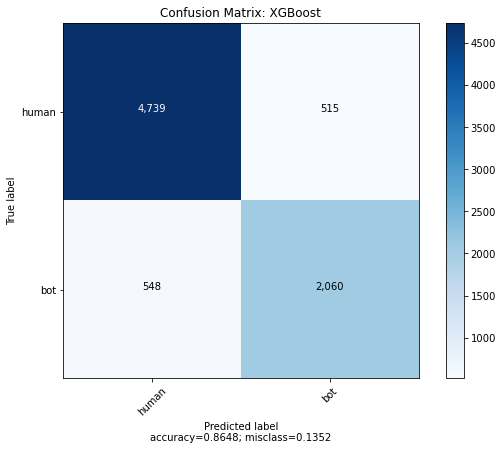

In [154]:
model = 'XGBoost'

xgb_cm = confusion_matrix(y_val, xgb_pred)
plot_cm(xgb_cm, normalize=False, target_names=['human', 'bot'], 
        title='Confusion Matrix: {}'.format(model))

# Evaluation

**Model Evaluation after Cross Validation**

**RandomForest with no parameter tuning**
```
RandomForest
------------
Accuracy:  0.87036 +- 0.003810
Precision: 0.82851 +- 0.019905        # Best Score
Recall:    0.76956 +- 0.018904
F1 Score:  0.79753 +- 0.007001
ROC AUC:   0.92606 +- 0.003713
```

**RandomForest Cross after tuning**

```
RandomForest
------------
Accuracy:  0.86755 +- 0.002660
Precision: 0.81540 +- 0.014635
Recall:    0.77607 +- 0.006013
F1 Score:  0.79518 +- 0.008127
ROC AUC:   0.92376 +- 0.003313
```
---

**XGBoost with no parameter tuning**
```
XGBoost
-------
Accuracy:  0.87259 +- 0.002498        # Best Score
Precision: 0.82089 +- 0.006591
Recall:    0.78777 +- 0.008624        # Best Score
F1 Score:  0.80395 +- 0.005084        # Best Score
ROC AUC:   0.92863 +- 0.003112        # Best Score
```

**XGBoost after tuning**

```
XGBoost cross-validated scoring
-------------------------------
Accuracy:  0.87109 +- 0.005812
Precision: 0.82466 +- 0.013785
Recall:    0.77784 +- 0.007421
F1 Score:  0.80047 +- 0.006394
ROC AUC:   0.92758 +- 0.001879

```